## Part 1: Building and Understanding GANs from Scratch

In [1]:
# Importing Required Libraries and Device setup
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
# Sine wave distribution
def sample_sine_wave(n_samples=512):
    x = np.random.uniform(-3, 3, n_samples)
    y = np.sin(x)
    data = np.stack([x, y], axis=1)
    return torch.tensor(data, dtype=torch.float32)

# Noisy parametric curve: y = sin(2x) + 0.3cos(5x) + noise
def sample_noisy_curve(n_samples=512):
    x = np.random.uniform(-3, 3, n_samples)
    epsilon = np.random.normal(0, 0.1, n_samples)
    y = np.sin(2 * x) + 0.3 * np.cos(5 * x) + epsilon
    data = np.stack([x, y], axis=1)
    return torch.tensor(data, dtype=torch.float32)


In [3]:
# Basic Generator and Discriminator

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )

    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [4]:
# GAN Training Function

def train_gan(data_fn, epochs=2000, batch_size=128):
    G = Generator().to(device)
    D = Discriminator().to(device)

    criterion = nn.BCELoss()
    optim_G = optim.Adam(G.parameters(), lr=1e-3)
    optim_D = optim.Adam(D.parameters(), lr=1e-3)

    for epoch in range(epochs):
        real_samples = data_fn(batch_size).to(device)
        z = torch.randn(batch_size, 2).to(device)
        fake_samples = G(z)

        # Train Discriminator
        D_real = D(real_samples)
        D_fake = D(fake_samples.detach())
        loss_D = criterion(D_real, torch.ones_like(D_real)) + criterion(D_fake, torch.zeros_like(D_fake))
        optim_D.zero_grad()
        loss_D.backward()
        optim_D.step()

        # Train Generator
        fake_samples = G(z)
        D_fake = D(fake_samples)
        loss_G = criterion(D_fake, torch.ones_like(D_fake))
        optim_G.zero_grad()
        loss_G.backward()
        optim_G.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch}: D Loss = {loss_D.item():.4f}, G Loss = {loss_G.item():.4f}")

    return G


In [5]:
# Visualization Function
def visualize_generator(G):
    with torch.no_grad():
        z = torch.randn(1000, 2).to(device)
        samples = G(z).cpu().numpy()
    plt.figure(figsize=(10, 5))
    plt.scatter(samples[:, 0], samples[:, 1], s=5, alpha=0.6, label="Generated")
    plt.title("Generated Samples")
    plt.legend()
    plt.grid(True)
    plt.show()


In [6]:
# Real vs Generated Comparison
def plot_real_vs_generated(G, data_fn, title="Real vs Generated"):
    real = data_fn(1000).numpy()
    with torch.no_grad():
        z = torch.randn(1000, 2).to(device)
        fake = G(z).cpu().numpy()
    plt.figure(figsize=(10, 5))
    plt.scatter(real[:, 0], real[:, 1], s=5, alpha=0.5, label="Real")
    plt.scatter(fake[:, 0], fake[:, 1], s=5, alpha=0.5, label="Generated")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


Epoch 0: D Loss = 1.3436, G Loss = 0.6876
Epoch 500: D Loss = 0.8444, G Loss = 1.0695
Epoch 1000: D Loss = 1.3495, G Loss = 0.7051
Epoch 1500: D Loss = 1.3367, G Loss = 0.7426


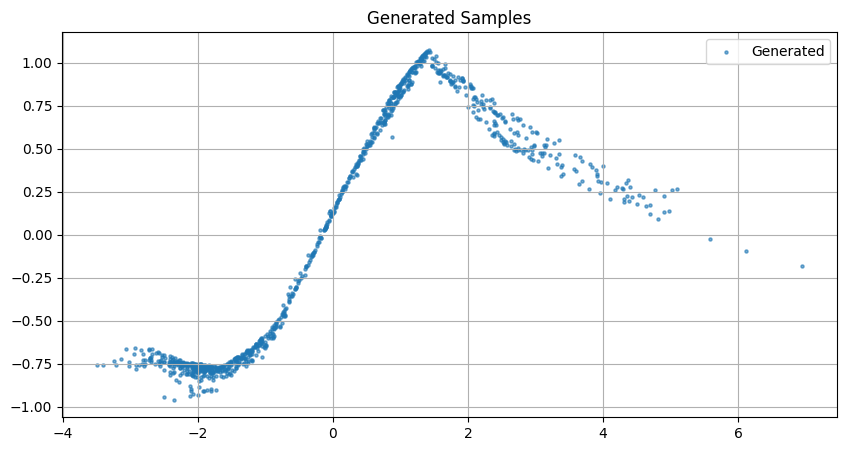

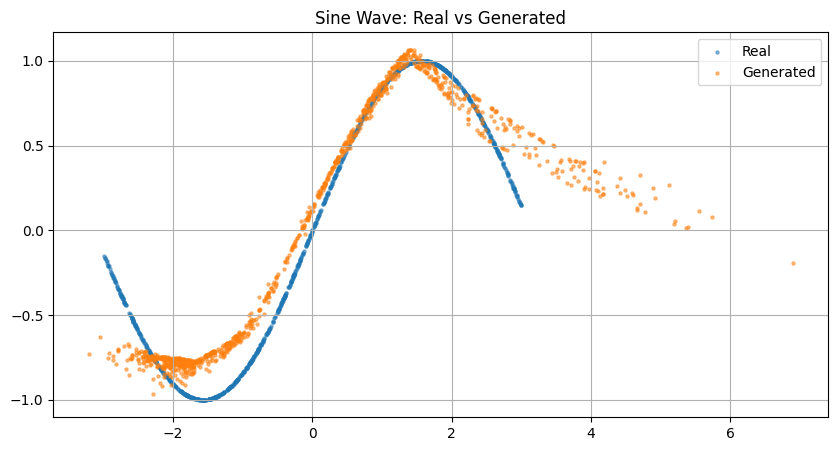

In [7]:
# Train sine GAN and Visualization
sine_G = train_gan(sample_sine_wave)
visualize_generator(sine_G)
plot_real_vs_generated(sine_G, sample_sine_wave, title="Sine Wave: Real vs Generated")


Epoch 0: D Loss = 1.4351, G Loss = 0.7964
Epoch 500: D Loss = 1.3177, G Loss = 0.8804
Epoch 1000: D Loss = 1.3611, G Loss = 0.7390
Epoch 1500: D Loss = 1.3464, G Loss = 0.9376


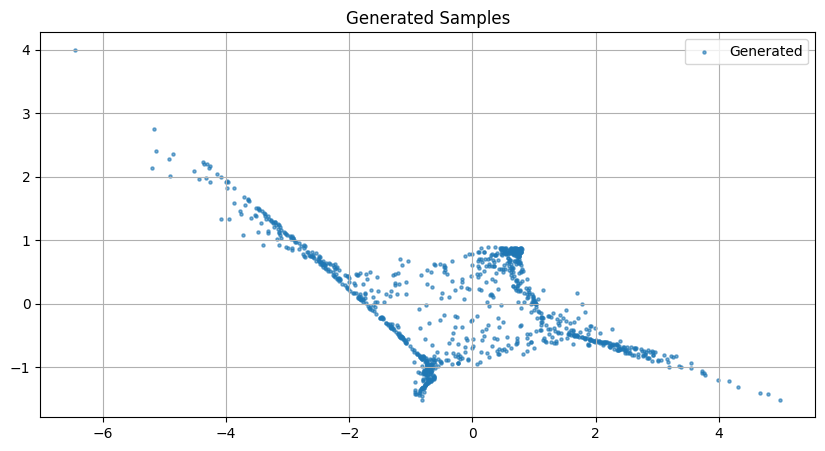

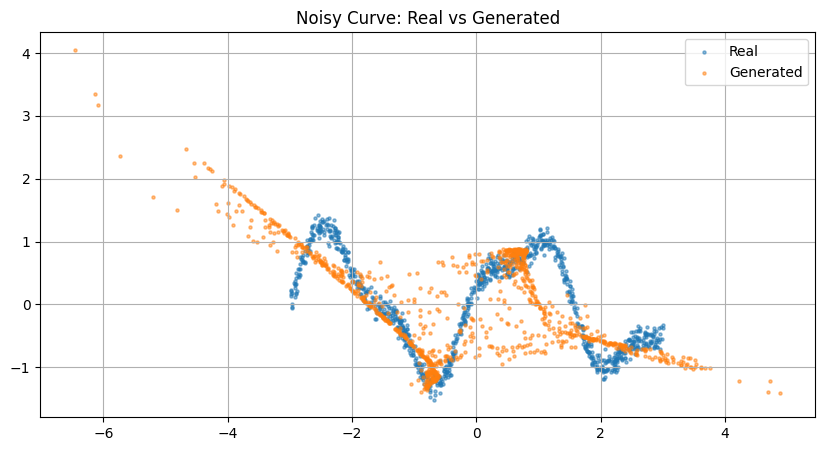

In [8]:
# Train GAN on Noisy Parametric Curve
noisy_G = train_gan(sample_noisy_curve)
visualize_generator(noisy_G)
plot_real_vs_generated(noisy_G, sample_noisy_curve, title="Noisy Curve: Real vs Generated")


In [9]:
# Modified Generator Architecture
class DeepGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 2)
        )

    def forward(self, z):
        return self.model(z)


In [10]:
# GAN Training with Deep Generator

def train_deep_gan(data_fn, epochs=2000, batch_size=128):
    G = DeepGenerator().to(device)
    D = Discriminator().to(device)

    criterion = nn.BCELoss()
    optim_G = optim.Adam(G.parameters(), lr=1e-3)
    optim_D = optim.Adam(D.parameters(), lr=1e-3)

    for epoch in range(epochs):
        real_samples = data_fn(batch_size).to(device)
        z = torch.randn(batch_size, 2).to(device)
        fake_samples = G(z)

        # Train Discriminator
        D_real = D(real_samples)
        D_fake = D(fake_samples.detach())
        loss_D = criterion(D_real, torch.ones_like(D_real)) + criterion(D_fake, torch.zeros_like(D_fake))
        optim_D.zero_grad()
        loss_D.backward()
        optim_D.step()

        # Train Generator
        fake_samples = G(z)
        D_fake = D(fake_samples)
        loss_G = criterion(D_fake, torch.ones_like(D_fake))
        optim_G.zero_grad()
        loss_G.backward()
        optim_G.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch}: D Loss = {loss_D.item():.4f}, G Loss = {loss_G.item():.4f}")

    return G


Epoch 0: D Loss = 1.3959, G Loss = 0.6554
Epoch 500: D Loss = 1.6335, G Loss = 0.4690
Epoch 1000: D Loss = 1.3721, G Loss = 0.7031
Epoch 1500: D Loss = 1.3925, G Loss = 0.6337


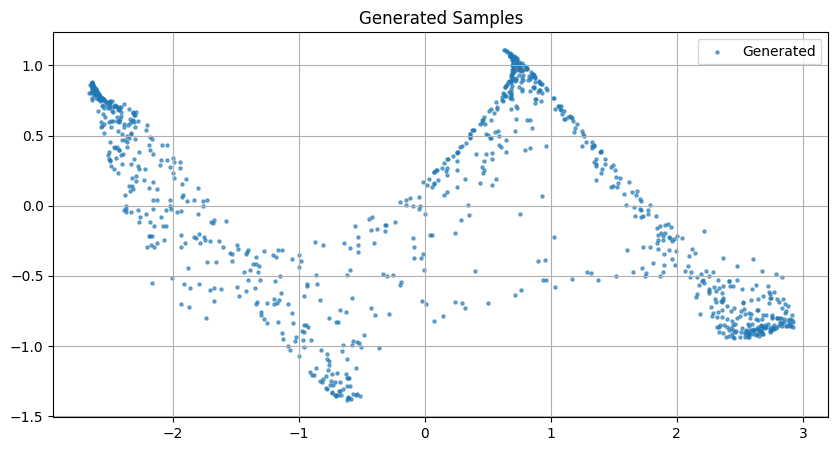

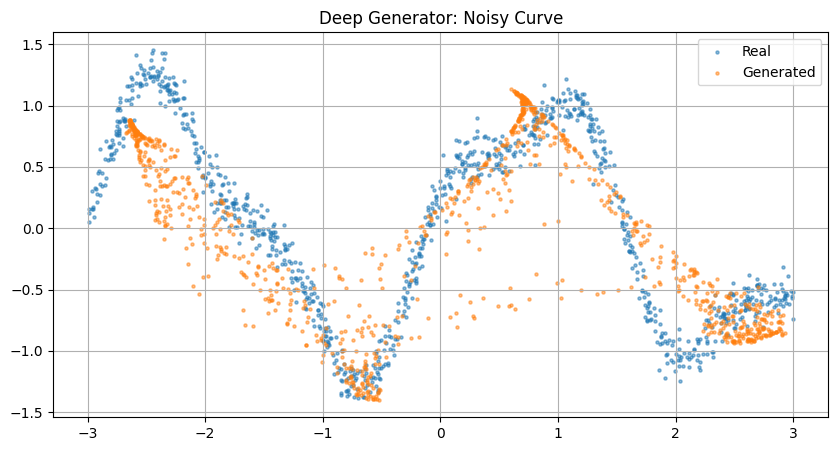

In [11]:
# Train and Compare Modified GAN
deep_G = train_deep_gan(sample_noisy_curve)
visualize_generator(deep_G)
plot_real_vs_generated(deep_G, sample_noisy_curve, title="Deep Generator: Noisy Curve")


## PART2: GAN Project: Cybersecurity – Synthetic Traffic with CICIDS 2017



In [12]:
# Install required packages
!pip install pandas matplotlib seaborn scikit-learn torch torchvision tqdm


In [13]:
from google.colab import drive
import pandas as pd
import os

# Mount Google Drive
drive.mount('/content/drive')

# Path to CICIDS2017 folder
data_folder = '/content/drive/MyDrive/CICIDS2017'

# Read all CSV files from the folder
csv_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith('.csv')]
print(f"Found {len(csv_files)} CSV files.")

dataframes = []
for file in csv_files:
    print(f"Reading: {file}")
    df = pd.read_csv(file, low_memory=False)
    df.columns = df.columns.str.strip()
    df["SourceFile"] = os.path.basename(file)
    dataframes.append(df)

df_full = pd.concat(dataframes, ignore_index=True)
print("Combined shape:", df_full.shape)

print("Columns now:")
print(df_full.columns.tolist())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 8 CSV files.
Reading: /content/drive/MyDrive/CICIDS2017/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
Reading: /content/drive/MyDrive/CICIDS2017/Friday-WorkingHours-Morning.pcap_ISCX.csv
Reading: /content/drive/MyDrive/CICIDS2017/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
Reading: /content/drive/MyDrive/CICIDS2017/Monday-WorkingHours.pcap_ISCX.csv
Reading: /content/drive/MyDrive/CICIDS2017/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
Reading: /content/drive/MyDrive/CICIDS2017/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
Reading: /content/drive/MyDrive/CICIDS2017/Tuesday-WorkingHours.pcap_ISCX.csv
Reading: /content/drive/MyDrive/CICIDS2017/Wednesday-workingHours.pcap_ISCX.csv
Combined shape: (2830743, 80)
Columns now:
['Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length o

In [14]:
# Keep only BENIGN and DDoS labels
df_filtered = df_full[df_full['Label'].isin(['BENIGN', 'DDoS'])].copy()

# Drop constant or all-null columns
df_filtered.dropna(axis=1, inplace=True)
df_filtered = df_filtered.loc[:, df_filtered.nunique() > 1]

# Separate features and labels
labels = df_filtered['Label']
features = df_filtered.drop(columns=['Label', 'SourceFile'], errors='ignore')

print(f"Cleaned dataset shape: {features.shape}")
features.head()


Cleaned dataset shape: (2401124, 69)


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,0,20,0.0,0.0,0,0,0.0,0.0,0,0
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,0,20,0.0,0.0,0,0,0.0,0.0,0,0
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,0,20,0.0,0.0,0,0,0.0,0.0,0,0
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0


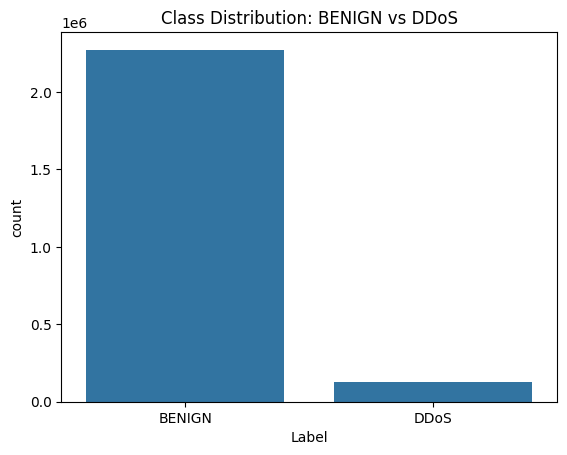

In [15]:
# Visualize Class Distribution
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=labels)
plt.title("Class Distribution: BENIGN vs DDoS")
plt.show()


In [17]:
import numpy as np

# Replace infinite values with NaN
features.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaNs
features = features.dropna()

# Drop corresponding labels
labels = labels.loc[features.index]

print(f"After cleaning, data shape: {features.shape}")


After cleaning, data shape: (2399345, 69)


In [18]:
# Normalize Features
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(features)

print("Normalized data shape:", normalized_data.shape)


Normalized data shape: (2399345, 69)


In [19]:
# Create PyTorch Dataset
import torch
from torch.utils.data import TensorDataset, DataLoader

batch_size = 64
tensor_data = torch.tensor(normalized_data, dtype=torch.float32)
dataset = TensorDataset(tensor_data)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

latent_dim = 100
feature_dim = normalized_data.shape[1]


In [20]:
# Define Generator and Discriminator

import torch.nn as nn

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, feature_dim),
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(feature_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [21]:
# Training Setup
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
G = Generator().to(device)
D = Discriminator().to(device)

criterion = nn.BCELoss()
optim_G = torch.optim.Adam(G.parameters(), lr=0.0002)
optim_D = torch.optim.Adam(D.parameters(), lr=0.0002)

G_losses, D_losses = [], []
epochs = 10


In [22]:
# Training the GAN

for epoch in range(epochs):
    g_loss_total = 0
    d_loss_total = 0

    for real_batch, in loader:
        real_batch = real_batch.to(device)
        batch_size = real_batch.size(0)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train Discriminator
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_data = G(z).detach()
        d_real = D(real_batch)
        d_fake = D(fake_data)
        d_loss = criterion(d_real, real_labels) + criterion(d_fake, fake_labels)

        optim_D.zero_grad()
        d_loss.backward()
        optim_D.step()

        # Train Generator
        z = torch.randn(batch_size, latent_dim).to(device)
        generated_data = G(z)
        g_loss = criterion(D(generated_data), real_labels)

        optim_G.zero_grad()
        g_loss.backward()
        optim_G.step()

        g_loss_total += g_loss.item()
        d_loss_total += d_loss.item()

    G_losses.append(g_loss_total / len(loader))
    D_losses.append(d_loss_total / len(loader))

    print(f"Epoch {epoch+1}/{epochs} | D Loss: {D_losses[-1]:.4f} | G Loss: {G_losses[-1]:.4f}")


Epoch 1/10 | D Loss: 0.7894 | G Loss: 1.7236
Epoch 2/10 | D Loss: 1.0159 | G Loss: 1.0970
Epoch 3/10 | D Loss: 1.0108 | G Loss: 1.1222
Epoch 4/10 | D Loss: 1.0030 | G Loss: 1.1386
Epoch 5/10 | D Loss: 1.0057 | G Loss: 1.1239
Epoch 6/10 | D Loss: 1.0096 | G Loss: 1.1104
Epoch 7/10 | D Loss: 1.0219 | G Loss: 1.0907
Epoch 8/10 | D Loss: 1.0287 | G Loss: 1.0778
Epoch 9/10 | D Loss: 1.0385 | G Loss: 1.0645
Epoch 10/10 | D Loss: 1.0463 | G Loss: 1.0558


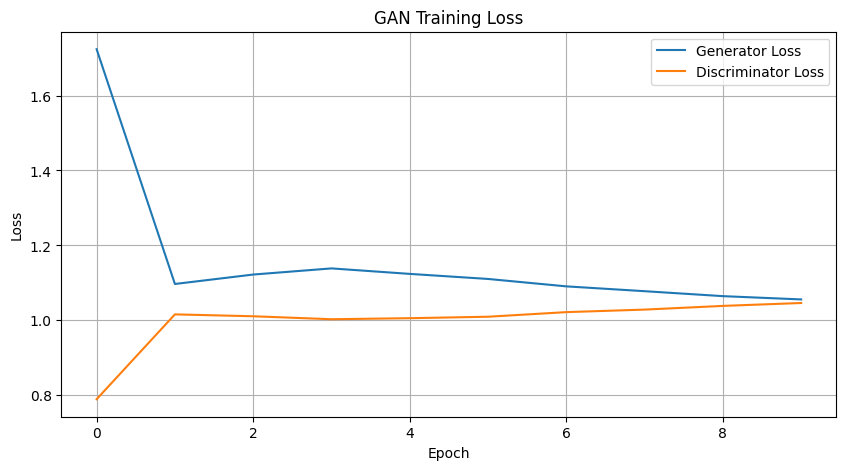

In [23]:
# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(G_losses, label='Generator Loss')
plt.plot(D_losses, label='Discriminator Loss')
plt.title("GAN Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


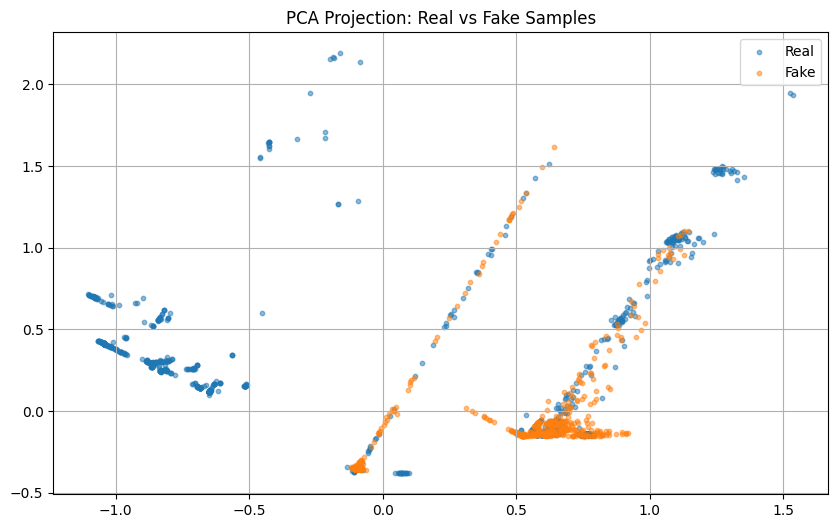

In [24]:
# Visualize Real vs Fake
from sklearn.decomposition import PCA
import numpy as np

# Generate synthetic data
G.eval()
with torch.no_grad():
    z = torch.randn(2000, latent_dim).to(device)
    fake_samples = G(z).cpu().numpy()

# Reduce both real and fake to 2D using PCA
pca = PCA(n_components=2)
real_pca = pca.fit_transform(normalized_data[:2000])
fake_pca = pca.transform(fake_samples)

plt.figure(figsize=(10, 6))
plt.scatter(real_pca[:, 0], real_pca[:, 1], alpha=0.5, label='Real', s=10)
plt.scatter(fake_pca[:, 0], fake_pca[:, 1], alpha=0.5, label='Fake', s=10)
plt.legend()
plt.title("PCA Projection: Real vs Fake Samples")
plt.grid(True)
plt.show()


In [25]:
# Evaluate Data Quality
real_df = pd.DataFrame(normalized_data[:2000], columns=features.columns)
fake_df = pd.DataFrame(fake_samples, columns=features.columns)

mean_diff = (real_df.mean() - fake_df.mean()).abs().sort_values(ascending=False)
print("Top 10 Features With Highest Mean Differences:")
print(mean_diff.head(10))


Top 10 Features With Highest Mean Differences:
ACK Flag Count            0.258000
Destination Port          0.101027
PSH Flag Count            0.090545
URG Flag Count            0.072000
Fwd IAT Total             0.050786
Flow Duration             0.050443
Bwd IAT Total             0.049760
Init_Win_bytes_forward    0.049136
SYN Flag Count            0.047500
Fwd PSH Flags             0.047500
dtype: float64
